In [1]:
# Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

In [2]:
#Load the chosen dataset
df = pd.read_csv("cybersecurity_attacks.csv", parse_dates=['Timestamp'])

Dimension (No.of Rows, No.of Columns) of the Dataset:  (40000, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Type            40000 non-null  object        
 9   Payload Data            40000 non-null  object        
 10  Malware Indicators      20000 non-null  object        
 11  Anomaly Scores          40000 non-null 

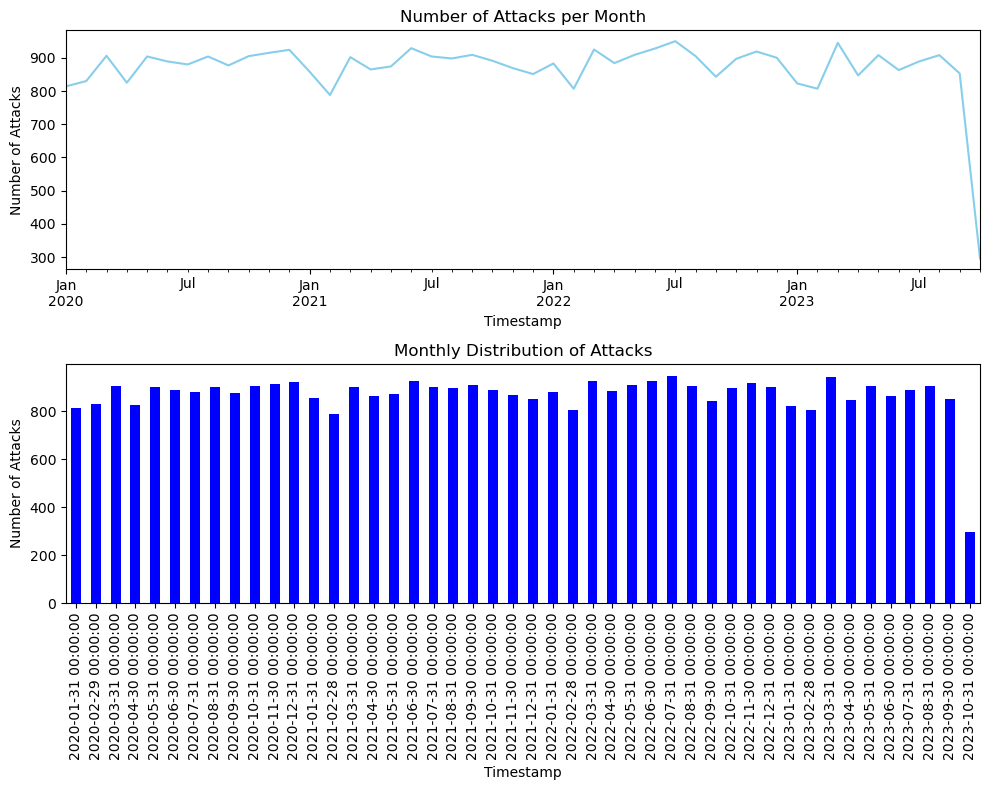

In [3]:
#Display the first 05 records in chosen dataset
df.head().T

#Dimension of the Dataset
print("Dimension (No.of Rows, No.of Columns) of the Dataset: ", df.shape)

#Dataset Information: Dimension, Column Names & its count, data types
print(df.info())

#Dataset Description: Statistical summary for numerical columns of the dataset
print(df.describe().T)

#Frequency of Attacks
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
monthly_attacks = df.resample('M', on='Timestamp')['Attack Type'].count()

print("Information on Frequncy of Attacks")
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

monthly_attacks.plot(ax=ax[0], color='skyblue')
ax[0].set_title('Number of Attacks per Month')
ax[0].set_ylabel('Number of Attacks')

monthly_attacks.plot(kind='bar', ax=ax[1], color='blue')
ax[1].set_title('Monthly Distribution of Attacks')
ax[1].set_ylabel('Number of Attacks')

plt.tight_layout()
plt.show()

Summary of the No.of Attacks Year wise
 Attack Type  DDoS  Intrusion  Malware
Year                                 
2020         3533       3551     3489
2021         3545       3475     3518
2022         3558       3563     3629
2023         2792       2676     2671


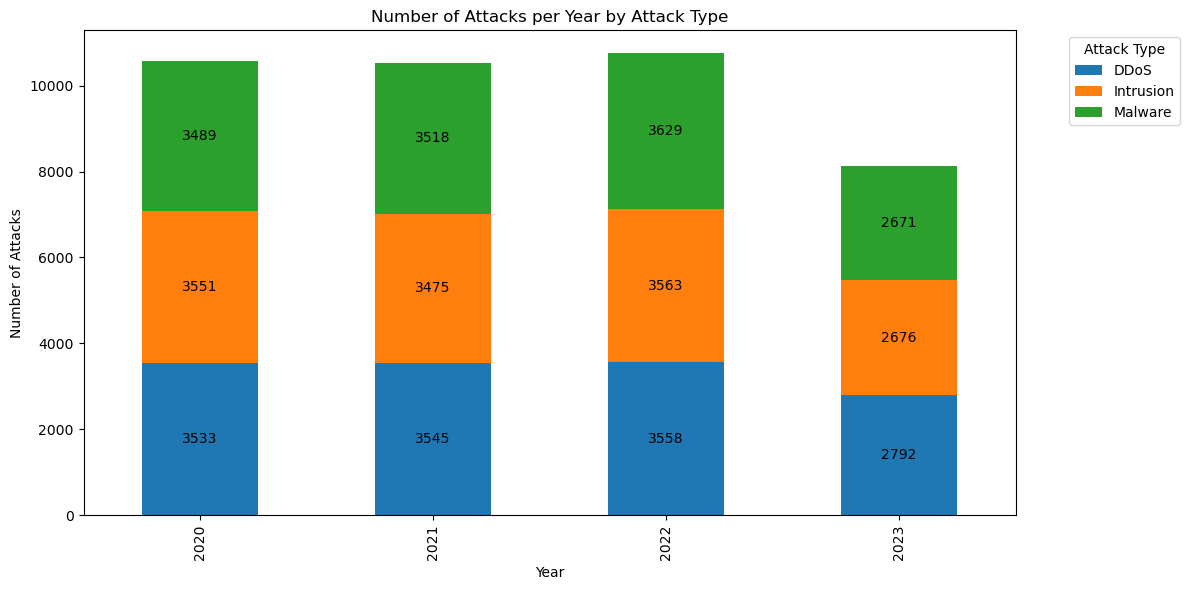

In [4]:
#Number of Attacks per year
df['Year']=df['Timestamp'].dt.year

# Group by YEAR and ATTACK TYPE, count occurrences
attack_counts = df.groupby(['Year', 'Attack Type']).size().unstack(fill_value=0)

# Print a summary of the data
print("Summary of the No.of Attacks Year wise\n",attack_counts)

# Plot the data
ax = attack_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize the plot
plt.title('Number of Attacks per Year by Attack Type')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, label_type='center')

# Show the plot
plt.show()

  Protocol Attack Type  COUNT
0     ICMP        DDoS   4508
6      UDP        DDoS   4482
2     ICMP     Malware   4461
1     ICMP   Intrusion   4460
3      TCP        DDoS   4438
5      TCP     Malware   4437
8      UDP     Malware   4409
7      UDP   Intrusion   4408
4      TCP   Intrusion   4397


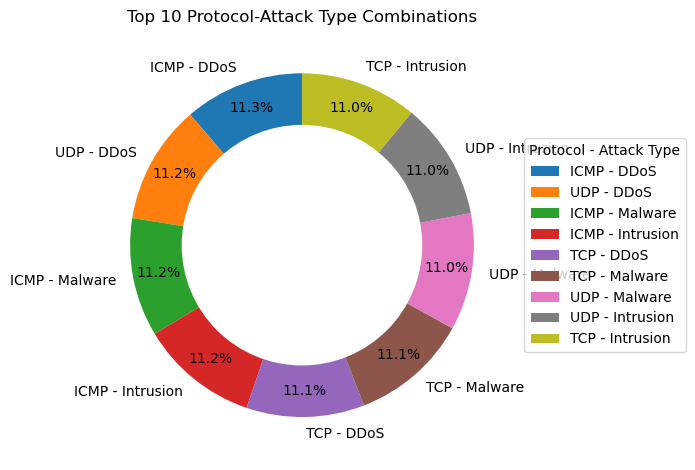

In [5]:
# Count occurrences of each combination of PROTOCOL and ATTACK TYPE
protocol_attack_counts = df.groupby(['Protocol', 'Attack Type']).size().reset_index(name='COUNT')

# Sort by count in descending order and take top 10 for better visibility
top_10 = protocol_attack_counts.sort_values('COUNT', ascending=False).head(10)

# Print a summary of the data
print(top_10)

# Create a pie chart
#ax = attack_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.plot(figsize=(12, 8))
plt.pie(top_10['COUNT'], labels=top_10.apply(lambda x: f"{x['Protocol']} - {x['Attack Type']}", axis=1),
autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Add a circle at the center to create a donut chart (optional)
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Add title
plt.title('Top 10 Protocol-Attack Type Combinations')
# Add legend
plt.legend(title='Protocol - Attack Type', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
# Adjust layout to prevent cutting off labels
plt.tight_layout()
# Show the plot
plt.show()

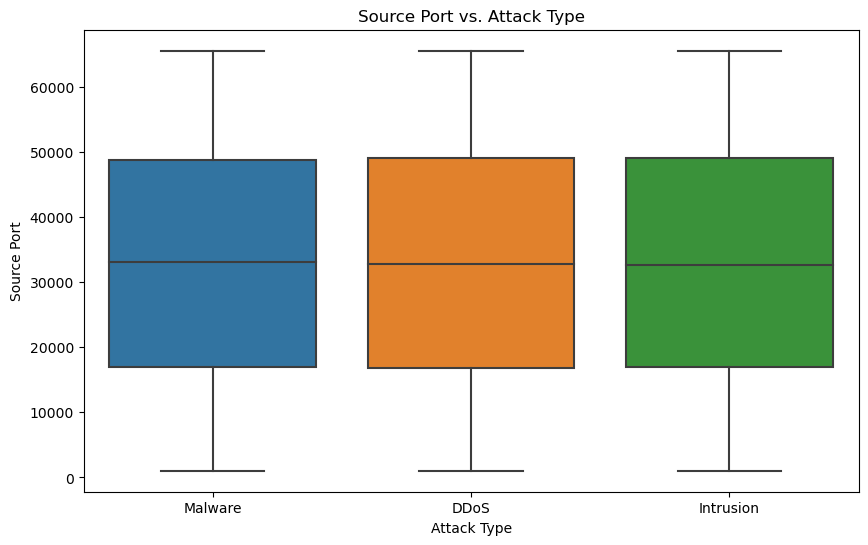

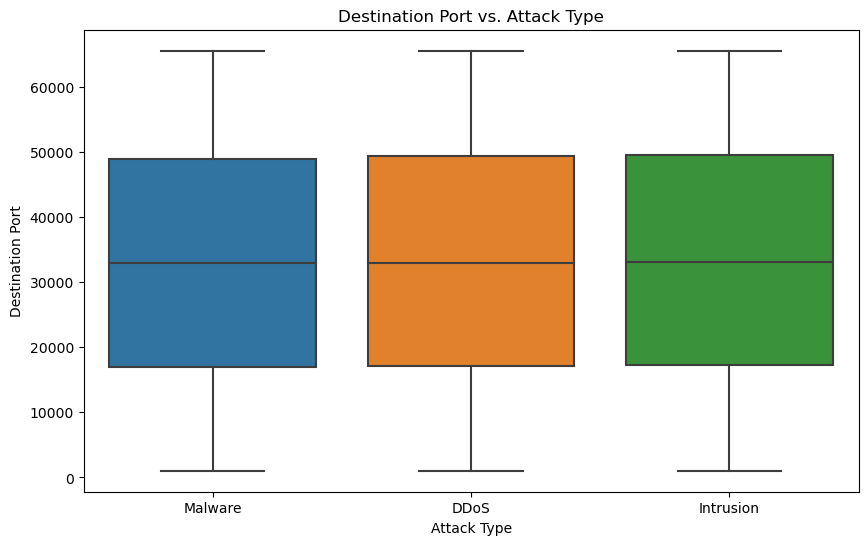

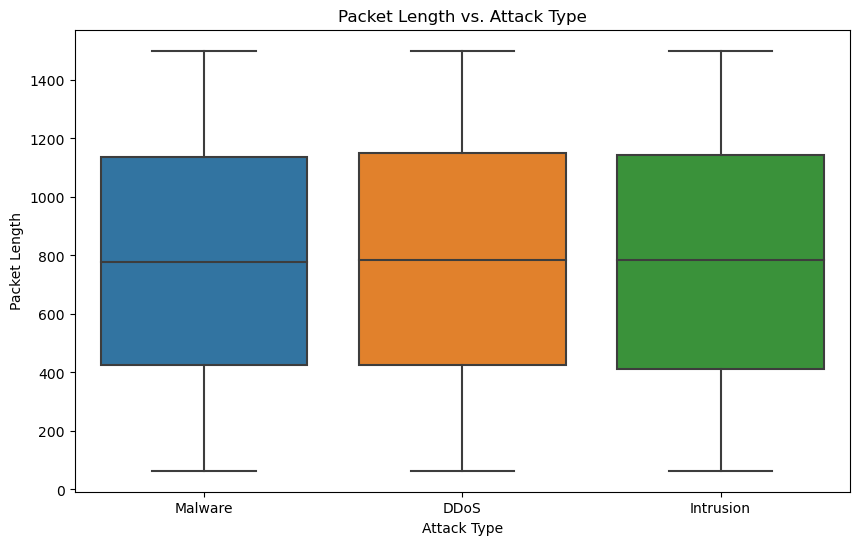

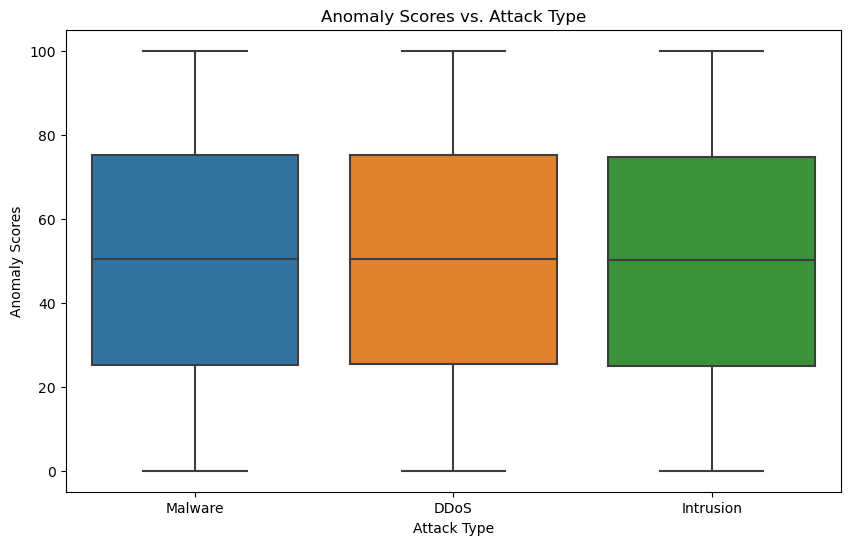

In [6]:
# Explore relationships between features and the target variable
# Select some features for visualization. Adjust based on actual features in your dataset.
features = ['Source Port', 'Destination Port', 'Packet Length', 'Anomaly Scores']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Attack Type', y=feature, data=df)
    plt.title(f'{feature} vs. Attack Type')
    plt.xlabel('Attack Type')
    plt.ylabel(feature)
    plt.show()

In [7]:
#Handling Missing values: Identify the columns with missing values and fill with 0
# Get column names with missing values
columns_with_missing = df.columns[df.isnull().any()].tolist()

# Print the result
print("Columns with missing values:")
for column in columns_with_missing:
    print(column)

# If you want to also see the count of missing values:
print("\nColumns with missing values and their counts:")
for column in columns_with_missing:
    missing_count = df[column].isnull().sum()
    print(f"{column}: {missing_count}")

# Fill the missing values with 0
df = df.fillna(0)
df.info()

#Convert some of the dataset values into integer
#convert the Timestamp into UNIX Epochs time which is in a long interger format
print("Timestamp values in YYYY-MM-DD HH:MM:SS format, \n",df['Timestamp'])

Columns with missing values:
Malware Indicators
Alerts/Warnings
Proxy Information
Firewall Logs
IDS/IPS Alerts

Columns with missing values and their counts:
Malware Indicators: 20000
Alerts/Warnings: 20067
Proxy Information: 19851
Firewall Logs: 19961
IDS/IPS Alerts: 20050
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Timestamp               40000 non-null  datetime64[ns]
 1   Source IP Address       40000 non-null  object        
 2   Destination IP Address  40000 non-null  object        
 3   Source Port             40000 non-null  int64         
 4   Destination Port        40000 non-null  int64         
 5   Protocol                40000 non-null  object        
 6   Packet Length           40000 non-null  int64         
 7   Packet Type             40000 non-null  object        
 8   Traffic Typ

In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%m/%d/%Y %I:%M:%S %p')
df['Timestamp'] = df['Timestamp'].apply(lambda x: int(x.timestamp()))
print("Timestamp in UNIX Epoch format:\n", df['Timestamp'])

#Convert the IP Addresses (Source IP Address & Destination IP Address) in the chosen Dataset into Integers
print("Before conversion the IP Addresses in the Dataset: \n",df.head())

def ip_to_int(ip):
    return int(ipaddress.ip_address(ip))

df['Destination IP Address'] = df['Destination IP Address'].apply(ip_to_int)
df['Source IP Address'] = df['Source IP Address'].apply(ip_to_int)
print("After conversion the IP Addresses in the Dataset: \n",df.head())

df.head(2).T

#Replace certain values with 1 for the columns where Firewall Logs value is 'Log Data', Malware Indicators value is 'IoC Detected' & Ale
df['Firewall Logs'] = df['Firewall Logs'].replace('Log Data', 1)
df['Malware Indicators'] = df['Malware Indicators'].replace('IoC Detected', 1)
df['Alerts/Warnings'] = df['Alerts/Warnings'].replace('Alert Triggered', 1)
print("After replacing certain values of columns: Firewall Log, Malware Indicators & Alerts/Warning with 1,\n")

df.head(2).T
#Drop columns: IDS/IPS Alerts and Proxy Information as these two feature has no valid contribution in our model
print("Dimension of Chosen Dataset: ", df.shape)
df = df.drop(columns=['IDS/IPS Alerts', 'Proxy Information', 'Year'])
print("Processed Dataset Dimension is, ", df.shape)

# Hot Encoding or Label Encoding, Converting the categorical values into numerical values
le = LabelEncoder()
df['Attack Type'] = le.fit_transform(df['Attack Type'])
df['Log Source'] = le.fit_transform(df['Log Source'])
df['Attack Signature'] = le.fit_transform(df['Attack Signature'])
df['Action Taken'] = le.fit_transform(df['Action Taken'])
df['Severity Level'] = le.fit_transform(df['Severity Level'])
df['User Information'] = le.fit_transform(df['User Information'])
df['Device Information'] = le.fit_transform(df['Device Information'])
df['Network Segment'] = le.fit_transform(df['Network Segment'])
df['Protocol'] = le.fit_transform(df['Protocol'])
df['Geo-location Data'] = le.fit_transform(df['Geo-location Data'])
df['Packet Type'] = le.fit_transform(df['Packet Type'])
df['Traffic Type'] = le.fit_transform(df['Traffic Type'])
df['Payload Data'] = le.fit_transform(df['Payload Data'])

df.info()

#Claculate the number of attacks using class variable: Attack Type
if 'Attack Type' in df.columns:
    attack_counts = df['Attack Type'].value_counts()
    
if not attack_counts.empty:
    le = LabelEncoder()
    le.fit(df['Attack Type'])
    class_names = le.inverse_transform(attack_counts.index)
    print("Attacks detected:")
    
attack_counts = df['Attack Type'].value_counts()
num_unique_attack_types = attack_counts.nunique()
print(f"Number of unique Attack Types: {num_unique_attack_types}")

class_names = {
0: "DDoS",
1: "Intrusion",
2: "Malware"
}

print("Unique Attack Types and their Counts:")
for attack_type, count in attack_counts.items():
    class_name = class_names.get(attack_type, "Unknown Class")
    print(f"{class_name} ({attack_type}): {count}")


Timestamp in UNIX Epoch format:
 0        1685428438
1        1598425710
2        1668327805
3        1688294326
4        1689513067
            ...    
39995    1685110122
39996    1679877507
39997    1648691149
39998    1695407558
39999    1696939192
Name: Timestamp, Length: 40000, dtype: int64
Before conversion the IP Addresses in the Dataset: 
     Timestamp Source IP Address Destination IP Address  Source Port  \
0  1685428438     103.216.15.12           84.9.164.252        31225   
1  1598425710    78.199.217.198         66.191.137.154        17245   
2  1668327805      63.79.210.48          198.219.82.17        16811   
3  1688294326     163.42.196.10        101.228.192.255        20018   
4  1689513067     71.166.185.76        189.243.174.238         6131   

   Destination Port Protocol  Packet Length Packet Type Traffic Type  \
0             17616     ICMP            503        Data         HTTP   
1             48166     ICMP           1174        Data         HTTP   
2     

Dimension of the Dataset:  (40000, 23)
Dimension of Feature Variables (X):  (40000, 22) Dimension of Target Variable (y):  (40000,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399998 entries, 0 to 399997
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Timestamp               399998 non-null  float64
 1   Source IP Address       399998 non-null  float64
 2   Destination IP Address  399998 non-null  float64
 3   Source Port             399998 non-null  float64
 4   Destination Port        399998 non-null  float64
 5   Protocol                399998 non-null  float64
 6   Packet Length           399998 non-null  float64
 7   Packet Type             399998 non-null  float64
 8   Traffic Type            399998 non-null  float64
 9   Payload Data            399998 non-null  float64
 10  Malware Indicators      399998 non-null  float64
 11  Anomaly Scores          399998 non-null  float64
 

Text(0.5, 1.0, 'Ditribution of Attacks (After Data Balancing)')

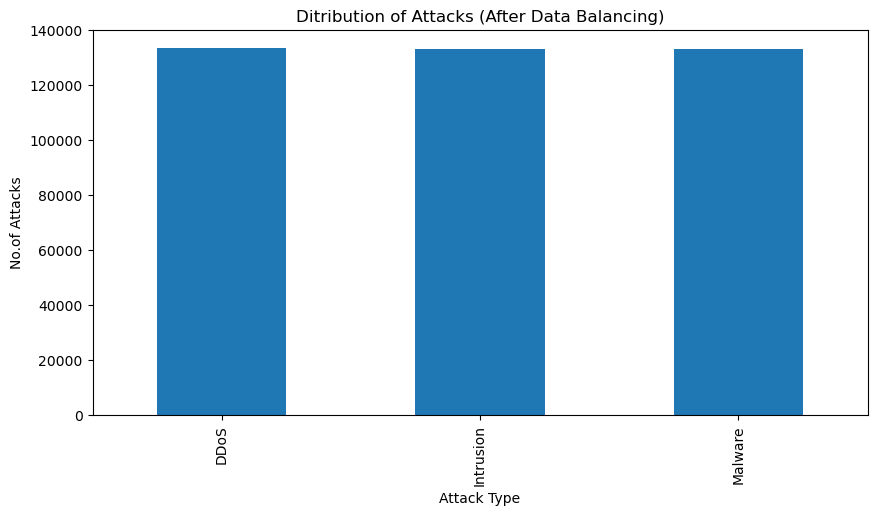

In [9]:
#Separate the Feature Variables (X) and Target/ Class Variables (y) in the Chosen Dataset
print("Dimension of the Dataset: ", df.shape)
X = df.drop(columns=['Attack Type'])
y = df['Attack Type']
print("Dimension of Feature Variables (X): ",X.shape,"Dimension of Target Variable (y): ", y.shape)

#Data balancing using SMOTE and Data Augmentation
target_size = 200000
class_counts = y.value_counts().to_dict()
total_samples_needed = target_size - len(y)
samples_per_class = {cls: count + total_samples_needed // len(class_counts) for cls, count in class_counts.items()}
smote = SMOTE(sampling_strategy=samples_per_class, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

def add_noise(dataframe, noise_level=0.01):
    noise = np.random.randn(*dataframe.shape) * noise_level
    dataframe_noisy = dataframe + noise
    return dataframe_noisy

numerical_columns = X_res.select_dtypes(include=[np.number]).columns
X_res_noisy = add_noise(X_res[numerical_columns])
X_augmented = pd.concat([X_res, X_res_noisy], ignore_index=True)
y_augmented = pd.concat([y_res, y_res], ignore_index=True)

df_resampled = X_augmented.copy()
df_resampled['Attack Type'] = y_augmented

df_resampled.info() #df_resampled.shape

#Number of Attack classes after Data Balancing
print("Number of Attack Classes: ",df_resampled['Attack Type'].unique())
print("\nNumber of Samples for each Attack Classes: ",df_resampled['Attack Type'].value_counts())

# Plotting the data samples after DATA BALANCING using SMOTE
plt.figure(figsize=(10,5))
df_resampled['Attack Type'].value_counts().plot(kind='bar')
plt.xticks([0,1,2], ['DDoS', 'Intrusion', 'Malware'])
plt.ylabel('No.of Attacks')
plt.title("Ditribution of Attacks (After Data Balancing)")

In [10]:
# Train-test split 80% 20%
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop(columns=['Attack Type']), df_resampled['Attack Type'], test_size=0.8)
print("After Splitting the Dataset,\nDimensions of TRAINING SET: ", X_train.shape,y_train.shape)
print("Dimensions of TESTING SET: ", X_test.shape,y_test.shape)
                                                    
X_train.head(2)
                                                    
y_train.head(2)
                                                    
X_test.head(2)
                                                    
y_test.head(2)                                          

After Splitting the Dataset,
Dimensions of TRAINING SET:  (79999, 22) (79999,)
Dimensions of TESTING SET:  (319999, 22) (319999,)


234754    0
317293    1
Name: Attack Type, dtype: int32

In [11]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical format
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("After Feature Scaling,\nDimensions of TRAINING SET: ", X_train.shape,y_train.shape)
print("Dimensions of TESTING SET: ", X_test.shape,y_test.shape)

After Feature Scaling,
Dimensions of TRAINING SET:  (79999, 22) (79999, 3)
Dimensions of TESTING SET:  (319999, 22) (319999, 3)


In [12]:
# Train test validation split 60% 20% 20%
X_train, X_temp, y_train, y_temp = train_test_split(df_resampled.drop(columns=['Attack Type']), df_resampled['Attack Type'], test_size=0.4)
print("After Splitting the Dataset,\nDimensions of TRAINING SET: ", X_train.shape,y_train.shape)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)
print("Dimensions of TESTING SET: ", X_test.shape,y_test.shape)
print("Dimensions of VALIDATION SET: ", X_val.shape,y_val.shape)
                                                    
print(X_train.head(2))
                                                    
print(y_train.head(2))
                                                    
print(X_test.head(2))
                                                    
print(y_test.head(2))   

print(X_val.head(2))

print(y_val.head(2))

After Splitting the Dataset,
Dimensions of TRAINING SET:  (239998, 22) (239998,)
Dimensions of TESTING SET:  (80000, 22) (80000,)
Dimensions of VALIDATION SET:  (80000, 22) (80000,)
           Timestamp  Source IP Address  Destination IP Address   Source Port  \
80521   1.605809e+09       2.816496e+09            2.594194e+09  13267.000000   
209492  1.660568e+09       5.074745e+08            1.619108e+09  43362.008895   

        Destination Port  Protocol  Packet Length  Packet Type  Traffic Type  \
80521       24558.000000  0.000000    1120.000000      0.00000      2.000000   
209492      20986.995833 -0.010255     499.988964     -0.01043      0.000417   

        Payload Data  ...  Alerts/Warnings  Attack Signature  Action Taken  \
80521   19315.000000  ...         0.000000          0.000000      1.000000   
209492   4814.992434  ...        -0.004741          0.997379     -0.002531   

        Severity Level  User Information  Device Information  Network Segment  \
80521         1.0

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert labels to categorical format
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

print("After Feature Scaling,\nDimensions of TRAINING SET: ", X_train.shape,y_train.shape)
print("Dimensions of TESTING SET: ", X_test.shape,y_test.shape)
print("Dimensions of VALIDATION SET: ", X_val.shape,y_val.shape)

After Feature Scaling,
Dimensions of TRAINING SET:  (239998, 22) (239998, 3)
Dimensions of TESTING SET:  (80000, 22) (80000, 3)
Dimensions of VALIDATION SET:  (80000, 22) (80000, 3)
